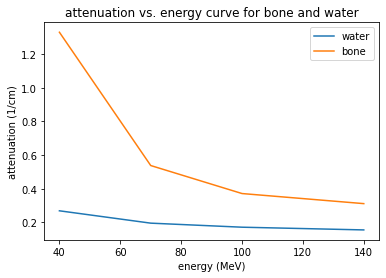

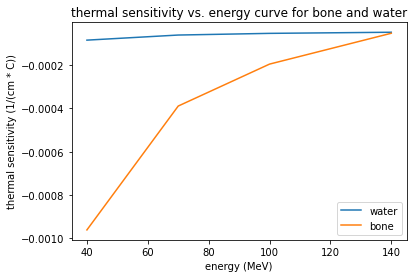

In [65]:
# DATA CALIBRATION FOR MODEL
# - attenuation vs. energy for water and bone
# - thermal sensitivity vs. energy for water and bone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random

# x_series: array of x values
# y_series: size n list of array of y values
# labels: size n list of labels corresponding to y_series
def line_plot(x_series, y_series, labels, title, ylabel, xlabel):
    for i in range(len(y_series)):
        plt.plot(x_series, y_series[i], label = labels[i])
        
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()

# source: https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/bone.html
energy_levels = np.array([40, 70, 100, 140]) # in keV/kvP
num_energy_levels = energy_levels.size

df_bone = pd.read_excel('bone_attenuation_curve.xlsx')
df_water = pd.read_excel('water_attenuation_curve.xlsx')
x_bone = np.array(df_bone['energy (keV)']) * 1000 # convert MeV to keV
y_bone = np.array(df_bone['mass attenuation (cm^2/g)'])
x_water = np.array(df_water['energy (keV)']) * 1000
y_water = np.array(df_water['mass attenuation (cm^2/g)'])

water_attenuations = np.array([])
bone_attenuations = np.array([])

for i in range(num_energy_levels):
    y_bone_new = np.interp(energy_levels[i], x_bone, y_bone)
    bone_attenuations = np.append(bone_attenuations, y_bone_new)
    y_water_new = np.interp(energy_levels[i], x_water, y_water)
    water_attenuations = np.append(water_attenuations, y_water_new)
    
bone_attenuations *= 2 # convert from mass attenuation (cm^2/g) to linear attenuation (1/cm)

# attenuation vs. energy plot
line_plot(energy_levels, 
          [water_attenuations, bone_attenuations],
          ['water', 'bone'], 
          'attenuation vs. energy curve for bone and water',
          'attenuation (1/cm)',
          'energy (keV)')
plt.show()

# source: https://link.springer.com/content/pdf/10.1007/s00330-021-08206-z.pdf       
water_alphas_HU = np.array([-0.32, -0.32, -0.32, -0.32])
bone_alphas_HU = np.array([-3.58, -2, -1.15, -0.35])
water_alphas = np.array([])
bone_alphas = np.array([])

for i in range(num_energy_levels):
    alpha_w = (water_alphas_HU[i]/1000) * water_attenuations[i]
    water_alphas = np.append(water_alphas, alpha_w)
    alpha_b = (bone_alphas_HU[i]/1000) * water_attenuations[i]
    bone_alphas = np.append(bone_alphas, alpha_b)

# thermal sensitivity vs. energy plot
line_plot(energy_levels, 
          [water_alphas, bone_alphas],
          ['water', 'bone'], 
          'thermal sensitivity vs. energy curve for bone and water',
          'thermal sensitivity (1/(cm * C))',
          'energy (keV)')
plt.show()

The volume fractions are: 
[0.33855995 0.34700817 0.31443188]


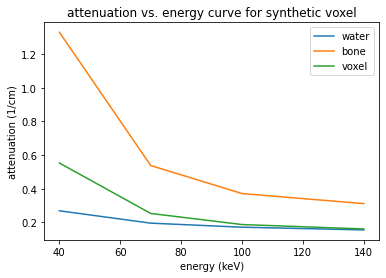

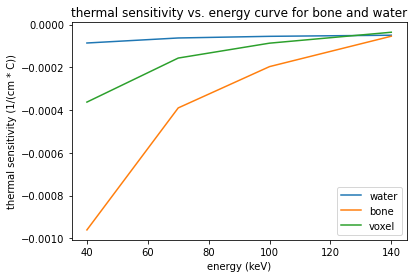

In [125]:
# GENERATE VOXEL

# randomly determine 3 volume fractions
volume_fractions = np.array([]) # idx0: V_w, idx1: V_b, idx2: V_a
num_bases = 3

for i in range(num_bases):
    volume_fractions = np.append(volume_fractions, random()) # range: [0, 1)
    
volume_fractions /= np.sum(volume_fractions) # normalize
print("The volume fractions are: ")
print(volume_fractions)

# attenuation of the voxel is a volume fraction weighted sum of the attenuations of bone and water
voxel_attenuations = np.array([])

for i in range(num_energy_levels):
    mu = volume_fractions[0] * water_attenuations[i] + volume_fractions[1] * bone_attenuations[i]
    voxel_attenuations = np.append(voxel_attenuations, mu)
    
# attenuation vs. energy of voxel
line_plot(energy_levels, 
          [water_attenuations, bone_attenuations, voxel_attenuations],
          ['water', 'bone', 'voxel'], 
          'attenuation vs. energy curve for synthetic voxel',
          'attenuation (1/cm)',
          'energy (keV)')
plt.show()

# thermal sensitivity of the voxel are volume fraction weighted sums of the thermal sensitivities of bone and water
voxel_alphas = np.array([])

for i in range(num_energy_levels):
    alpha_wb = volume_fractions[0] * water_alphas[i] + volume_fractions[1] * bone_alphas[i]
    voxel_alphas = np.append(voxel_alphas, alpha_wb)

# thermal sensitivity vs. energy of voxel
line_plot(energy_levels, 
          [water_alphas, bone_alphas, voxel_alphas],
          ['water', 'bone', 'voxel'], 
          'thermal sensitivity vs. energy curve for bone and water',
          'thermal sensitivity (1/(cm * C))',
          'energy (keV)')
plt.show()

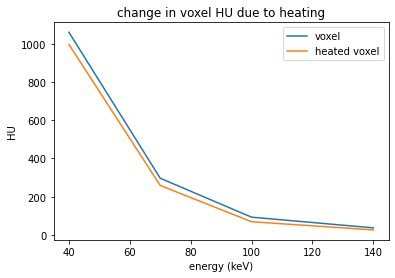

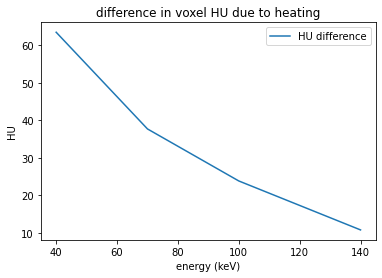

In [126]:
# HEAT VOXEL

gt_temp = 70
heated_voxel_attenuations = np.copy(voxel_attenuations)

# we assume a linear model for mu vs. temperature
for i in range(num_energy_levels):
    heated_voxel_attenuations[i] += (gt_temp - 23) * voxel_alphas[i] # assume background temperature of 23 C

# convert from linear attenuation to HU
voxel_HU = ((voxel_attenuations - water_attenuations) / water_attenuations) * 1000
heated_voxel_HU = ((heated_voxel_attenuations - water_attenuations) / water_attenuations) * 1000
delta_HU = voxel_HU - heated_voxel_HU

line_plot(energy_levels, 
          [voxel_HU, heated_voxel_HU],
          ['voxel', 'heated voxel'], 
          'change in voxel HU due to heating',
          'HU',
          'energy (keV)')
plt.show()

line_plot(energy_levels, 
          [delta_HU],
          ['HU difference'], 
          'difference in voxel HU due to heating',
          'HU',
          'energy (keV)')
plt.show()

In [127]:
# METHOD 1: UNCORRECTED MATERIAL DECOMPOSITION

col_1 = np.expand_dims(water_attenuations, axis=1)
col_2 = np.expand_dims(bone_attenuations, axis=1)
col_3 = np.expand_dims(np.zeros(4), axis=1)
row_5 = np.expand_dims(np.ones(3), axis=0)

coefficient_mtx = np.append(col_1, col_2, axis=1)
coefficient_mtx = np.append(coefficient_mtx, col_3, axis=1)
coefficient_mtx = np.append(coefficient_mtx, row_5, axis=0)
#print(coefficient_mtx.shape)

conditions = np.expand_dims(np.append(heated_voxel_attenuations, 1), axis=1)
inverse = np.linalg.pinv(coefficient_mtx)
#print(inverse.shape)

uncorrected_volume_fractions = np.matmul(inverse, conditions)
print((uncorrected_volume_fractions.flatten() - volume_fractions) * 100)


pred_temp_arr = np.array([])

for i in range(num_energy_levels):
    alpha_wb = uncorrected_volume_fractions[0] * water_alphas_HU[i] + uncorrected_volume_fractions[1] * bone_alphas_HU[i] 
    pred_temp_arr = np.append(pred_temp_arr, -delta_HU[i]/alpha_wb + 23)
    
print(pred_temp_arr)

[ 1.02272851 -1.50372013  0.48099162]


In [151]:
# METHOD 2: CORRECTED MATERIAL DECOMPOSITION AND TEMPERATURE PREDICTION

col_1 = np.expand_dims(water_attenuations, axis=1)
col_2 = np.expand_dims(bone_attenuations, axis=1)
col_3 = np.expand_dims(np.zeros(4), axis=1)
col_4 = np.expand_dims(water_alphas, axis=1)
col_5 = np.expand_dims(bone_alphas, axis=1)

row_5 = np.expand_dims(np.array([1, 1, 1, 0, 0]), axis=0)

coefficient_mtx = np.append(col_1, col_2, axis=1)
coefficient_mtx = np.append(coefficient_mtx, col_3, axis=1)
coefficient_mtx = np.append(coefficient_mtx, col_4, axis=1)
coefficient_mtx = np.append(coefficient_mtx, col_5, axis=1)
coefficient_mtx = np.append(coefficient_mtx, row_5, axis=0)
print(coefficient_mtx.shape)

conditions = np.expand_dims(np.append(heated_voxel_attenuations, 1), axis=1)
print(conditions.shape)
inverse = np.linalg.pinv(coefficient_mtx)
print(inverse.shape)

output = np.matmul(inverse, conditions)

(5, 5)
(5, 1)
(5, 5)
[-1.3381015e-05]


In [142]:
row_5 = np.expand_dims(np.array([1, 1, 1, 0, 0]), axis=0)
row_5.shape

(1, 5)